In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set a nice theme
sns.set(style='whitegrid')

# Load the cleaned dataset
df = pd.read_csv('student+performance/student/student_combined_processed.csv', sep=',')

print("Data loaded successfully!")
print("Shape:", df.shape)
df.head()

Data loaded successfully!
Shape: (1044, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,subject,G3,pass
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,6,0,6,0
1,0,0,17,1,0,1,1,1,0,2,...,5,3,3,1,1,3,4,0,6,0
2,0,0,15,1,1,1,1,1,0,2,...,4,3,2,2,3,3,10,0,10,1
3,0,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,2,0,15,1
4,0,0,16,1,0,1,3,3,2,2,...,4,3,2,1,2,5,4,0,10,1


In [2]:
print("Existing columns:", df.columns.tolist())

grade_columns = []
for col in ['G1', 'G2', 'G3', 'final_grade', 'third_period']:
    if col in df.columns:
        grade_columns.append(col)

# Create binary target variable using the final grade column
final_grade_col = grade_columns[-1]
df['pass'] = df[final_grade_col].apply(lambda x: 1 if x >= 10 else 0)

# Dropping original grade columns to prevent data leakage
df = df.drop(grade_columns, axis=1)

# Displaying class distribution
print("\nTarget variable distribution:")
print(df['pass'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))


Existing columns: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'subject', 'G3', 'pass']

Target variable distribution:
pass
1    78.0%
0    22.0%
Name: proportion, dtype: object


In [3]:
# Step 4: Handle Categorical Variables
# Select categorical columns (modify if your DataFrame has different types)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("\nAfter encoding categorical features:")
print(f"New shape: {df_encoded.shape}")
print(f"Example features: {list(df_encoded.columns[:5])}...")



After encoding categorical features:
New shape: (1044, 32)
Example features: ['school', 'sex', 'age', 'address', 'famsize']...


In [4]:
# Step 5: Train-Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_encoded.drop('pass', axis=1)
y = df_encoded['pass']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features (for models that need it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")


Data split:
Train: 730 samples
Test: 314 samples


/var/folders/02/46yf_glx3t34dd2pdqj89q200000gn/T/ipykernel_3811/3202309492.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pass', data=df_encoded, palette='viridis')


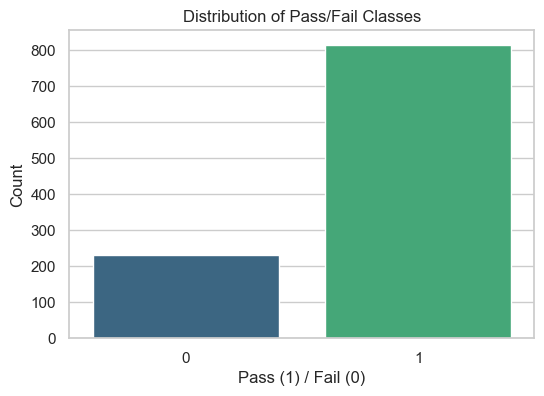

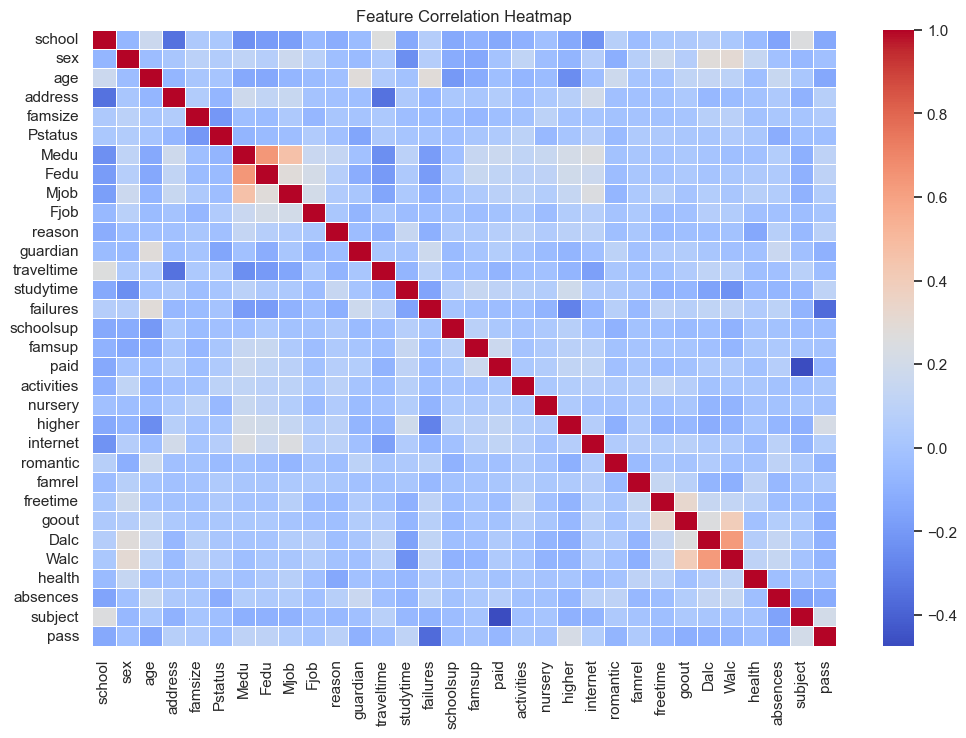

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure df_encoded exists
if 'df_encoded' not in locals():
    raise ValueError("The DataFrame 'df_encoded' is not defined. Please ensure all previous steps are executed.")

# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='pass', data=df_encoded, palette='viridis')
plt.title('Distribution of Pass/Fail Classes')
plt.xlabel('Pass (1) / Fail (0)')
plt.ylabel('Count')
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier()
}

# Verify train-test split exists
if 'X_train' not in locals():
    from sklearn.model_selection import train_test_split
    X = df_encoded.drop('pass', axis=1)
    y = df_encoded['pass']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train and evaluate models
results = {}
for name, clf in classifiers.items():
    # Use scaled data only for models that need it
    if name in ['Logistic Regression', 'SVM', 'KNN']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Store results
    results[name] = {
        'Accuracy': f"{accuracy:.2f}",
        'Precision': f"{precision:.2f}",
        'Recall': f"{recall:.2f}",
        'F1 Score': f"{f1:.2f}",
        'Confusion Matrix': cm
    }

# Print results
print("Model Evaluation Results:\n")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"Precision: {metrics['Precision']}")
    print(f"Recall: {metrics['Recall']}")
    print(f"F1 Score: {metrics['F1 Score']}")
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])
    print("\n" + "-"*50 + "\n")

Model Evaluation Results:

Logistic Regression:
Accuracy: 0.78
Precision: 0.82
Recall: 0.93
F1 Score: 0.87
Confusion Matrix:
[[ 18  51]
 [ 18 227]]

--------------------------------------------------

Random Forest:
Accuracy: 0.80
Precision: 0.82
Recall: 0.95
F1 Score: 0.88
Confusion Matrix:
[[ 19  50]
 [ 12 233]]

--------------------------------------------------

XGBoost:
Accuracy: 0.77
Precision: 0.83
Recall: 0.89
F1 Score: 0.86
Confusion Matrix:
[[ 24  45]
 [ 28 217]]

--------------------------------------------------

SVM:
Accuracy: 0.81
Precision: 0.82
Recall: 0.97
F1 Score: 0.89
Confusion Matrix:
[[ 16  53]
 [  7 238]]

--------------------------------------------------

KNN:
Accuracy: 0.79
Precision: 0.81
Recall: 0.94
F1 Score: 0.87
Confusion Matrix:
[[ 16  53]
 [ 14 231]]

--------------------------------------------------



In [7]:
# Get the best model
best_model = classifiers['Random Forest']

# Extract feature importances
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
else:
    # For models like Logistic Regression, use coefficients
    importances = best_model.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Display top 10 features
print("Top Features Affecting Pass/Fail:")
print(feature_importance.head(10))


Top Features Affecting Pass/Fail:
     Feature  Importance
14  failures    0.118310
29  absences    0.085221
30   subject    0.053960
25     goout    0.046271
2        age    0.045042
24  freetime    0.040183
23    famrel    0.039039
6       Medu    0.037205
28    health    0.036782
27      Walc    0.036762


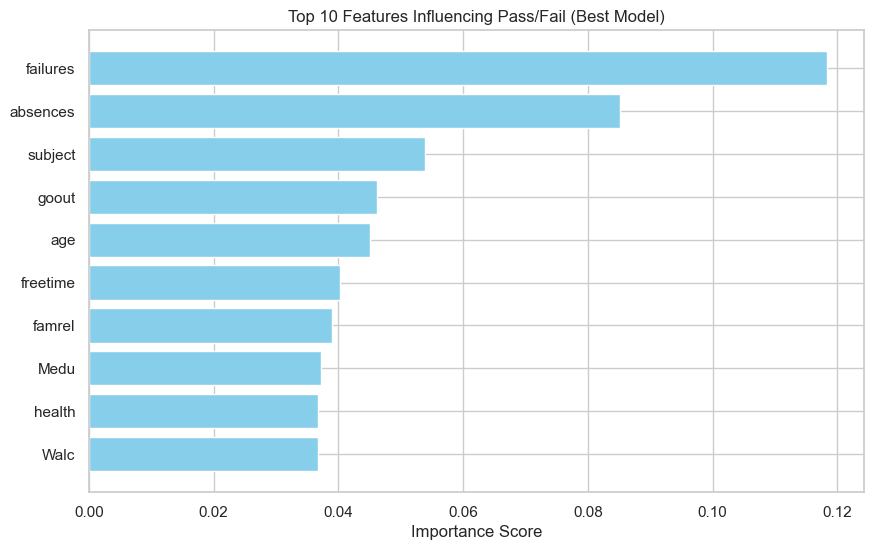

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10), color='skyblue')
plt.title('Top 10 Features Influencing Pass/Fail (Best Model)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()


In [9]:
f""" the below code blocks are completely optional and might probably remove them"""

' the below code blocks are completely optional and might probably remove them'

In [10]:
# Get top 5 features from the best model
top_features = feature_importance.head(5)['Feature'].tolist()

# Define interventions based on common features
intervention_map = {
    'absences': "**High Absences**: Students with >5 absences need attendance counseling.",
    'failures': "**Prior Failures**: Students with past failures require remedial classes.",
    'studytime': "**Low Study Time**: Organize study workshops for students with <2hrs daily study.",
    'famrel': "**Family Support**: Provide family counseling for students with poor family relationships.",
    'Dalc': "**Alcohol Use**: Launch awareness programs for students with high weekday alcohol consumption.",
    'health': "**Health Issues**: Connect students with poor health to wellness resources.",
    'goout': "**Social Overload**: Encourage time management for students who go out excessively.",
    'G1': "**Low Prior Grades (G1)**: Assign tutors to students with poor initial grades.",
    'G2': "**Low Midterm Grades (G2)**: Offer extra credit opportunities.",
    'schoolsup': "**School Support**: Ensure at-risk students enroll in school support programs."
}

print("**Actionable Interventions Based on Key Features:**")
for feature in top_features:
    # Clean feature name (remove one-hot encoded suffixes)
    base_feature = feature.split('_')[0]
    if base_feature in intervention_map:
        print(f"\n- {intervention_map[base_feature]}")
    else:
        print(f"\n- **{feature}**: Investigate how this factor impacts student performance.")

# Add general recommendation
print("\n**General Recommendation**: Prioritize students with multiple risk factors for early intervention.")


**Actionable Interventions Based on Key Features:**

- **Prior Failures**: Students with past failures require remedial classes.

- **High Absences**: Students with >5 absences need attendance counseling.

- **subject**: Investigate how this factor impacts student performance.

- **Social Overload**: Encourage time management for students who go out excessively.

- **age**: Investigate how this factor impacts student performance.

**General Recommendation**: Prioritize students with multiple risk factors for early intervention.


In [11]:
import joblib
import os

# Define the full path to your Google Drive models directory
save_path = "models"

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Save each trained model into the Google Drive folder
for name, model in classifiers.items():
    filename = f"{save_path}/{name.lower().replace(' ', '_')}_classification_model.joblib"
    joblib.dump(model, filename)
    print(f"Saved: {filename}")

Saved: models/logistic_regression_classification_model.joblib
Saved: models/random_forest_classification_model.joblib
Saved: models/xgboost_classification_model.joblib
Saved: models/svm_classification_model.joblib
Saved: models/knn_classification_model.joblib


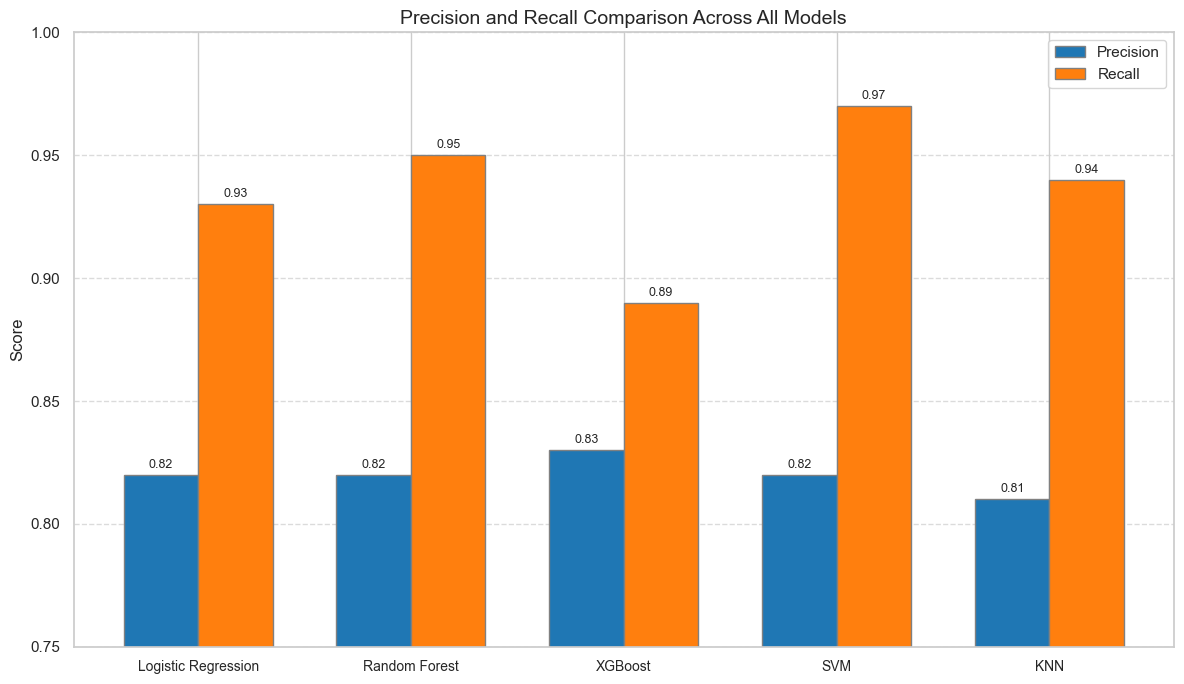

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'KNN']
precision_scores = [0.82, 0.82, 0.83, 0.82, 0.81]
recall_scores = [0.93, 0.95, 0.89, 0.97, 0.94]

# Number of models
n_models = len(models)
# Position of bars on x-axis
bar_positions = np.arange(n_models)
# Width of the bars
bar_width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7)) # Adjust figure size for better readability

# Plotting the bars
rects1 = ax.bar(bar_positions - bar_width/2, precision_scores, bar_width, label='Precision', color='#1f77b4', edgecolor='grey')
rects2 = ax.bar(bar_positions + bar_width/2, recall_scores, bar_width, label='Recall', color='#ff7f0e', edgecolor='grey')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision and Recall Comparison Across All Models', fontsize=14)
ax.set_xticks(bar_positions)
ax.set_xticklabels(models, rotation=0, ha='center', fontsize=10) # Use rotation=0 for short names

# Add a legend
ax.legend()

# Add a horizontal grid for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits to better show differences
ax.set_ylim(0.75, 1.0) # Adjust based on your score range if needed

# Add score values on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

autolabel(rects1)
autolabel(rects2)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()